In [1]:
import os
import getpass
from dotenv import load_dotenv

from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

from tools.polygon.news import TickerNews
from tools.math.multiply import Multiply
from tools.time.current import CurrentTimeTool

from pydantic import BaseModel, Field


# Load environment variables from .env file
load_dotenv()

polygon_api_key = os.getenv("POLYGON_API_KEY")

ticker_news = TickerNews(api_key=polygon_api_key)
multiply = Multiply()
current_time_in = CurrentTimeTool()

llm = ChatOllama(model='llama3.2', temperature=0)
llm_with_tools = llm.bind_tools([multiply, current_time_in, ticker_news])

available_tools = { 
    "multiply": multiply, 
    "current_time_in": current_time_in, 
    "ticker_news": ticker_news ,
}


In [2]:

# Graph state
class State(TypedDict):
    user_query: str
    tool_calls: str
    output: str

check_field_presence_prompt = """
User asked this question:
{user_query}

Here is the field description:
{field_description}

Here is the field type:
{field_type}

Here is the field value:
{field_value}

You are a helpful assistant that can help me to check if the field is present in the user query. 
You will be given a user query and a field name and description.
You need to check if the field whith specified type is present in the user query.

If fields type doesn't match, you need to return False.
If field is not present, you need to return False.
Otherwise return True.
"""

# check_field_presence_prompt = """
# You are a helpful assistant that can help me to check if the field is present in the user query. 
# You will be given a user query and a field name and description.
# You need to check if the field whith specified type is present in the user query.

# If fields type doesn't match, you need to return False.
# If field is not present, you need to return False.
# Otherwise return True.

# Here is the user query:
# {user_query}

# Here is the field name:
# {field_name}

# Here is the field type:
# {field_type}

# Here is the field value:
# {field_value}

# Here is the field description:
# {field_description}
# """

class CheckFieldPresence(BaseModel):
    presence: bool = Field(None, description="Defines if the field is present in the file.")

# Augment the LLM with schema for structured output
field_presence_llm = llm.with_structured_output(CheckFieldPresence)


# Nodes
def select_tools(state: State):
    msg = llm_with_tools.invoke(state['user_query'])
    return {"tool_calls": msg.tool_calls}

def validate_tool_inputs(state: State):
    tool_calls = state['tool_calls']
    new_tool_calls = []
    for tool_call in tool_calls:
        new_tool_call = tool_call.copy()
        new_tool_call['arg_validation_msgs'] = {}
        for key, value in new_tool_call['args'].items():
            
            q = check_field_presence_prompt.format(
                user_query=state['user_query'],
                field_name=key,
                field_value=value,
                field_type=available_tools[new_tool_call['name']].args[key]['type'],
                field_description=available_tools[new_tool_call['name']].args[key]['description']
            )
            # print("Validating tool call", q)
            # print("--------------------------------")
            field_presence_result = field_presence_llm.invoke(q)
            
            # TODO: add validation result to the tool call
            # new_tool_call['arg_validation_msgs'][key] = field_presence_result.presence
            new_tool_call['arg_validation_msgs'][key] = True

        new_tool_calls.append(new_tool_call)

    return {"tool_calls": new_tool_calls}

def execute_tool_call(state: State):

    messages = [HumanMessage(state['user_query'])]
    ai_msg = llm_with_tools.invoke(messages)
    messages.append(ai_msg)

    for tool_call in ai_msg.tool_calls:
        selected_tool = { 
            "multiply": multiply, 
            "current_time_in": current_time_in, 
            "ticker_news": ticker_news }[tool_call['name'].lower()]
        
        # print("EXPECTED TOOL CALL",  state['tool_calls'])

        tool_msg = selected_tool.invoke(tool_call)
        messages.append(tool_msg)

    result_msg = llm_with_tools.invoke(messages)

    return {"output": result_msg.content}

workflow = StateGraph(State)
workflow.add_node("select_tools", select_tools)
workflow.add_edge(START, "select_tools")

workflow.add_node("validate_tool_inputs", validate_tool_inputs)
workflow.add_edge("select_tools", "validate_tool_inputs")

workflow.add_node("execute_tool_call", execute_tool_call)
workflow.add_edge("validate_tool_inputs", "execute_tool_call")

workflow.add_edge("execute_tool_call", END)

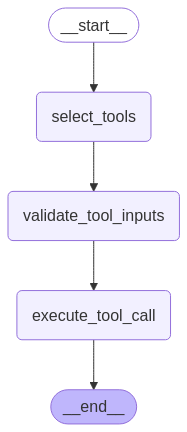

TOOL CALL: Getting news for AMZN
TOOL RESPONSE: b'{"results":{"name":"Amazon.Com Inc","composite_figi":"BBG000BVPV84","cik":"0001018724","events":[{"ticker_change":{"ticker":"AMZN"},"type":"ticker_change","date":"2003-09-10"}]},"status":"OK","request_id":"afb3eed84d08e825b3f748f618b3d8a5"}'
GOT RESULT Here's the formatted answer to your original user question:

"News for AMZN ticker:

Amazon.com Inc. is a technology company that was founded in 1994 by Jeff Bezos. The company is known for its e-commerce platform, cloud computing services, and artificial intelligence technologies.

As of September 10, 2003, Amazon's ticker symbol changed to BBG000BVPV84. The company has since become one of the world's largest and most influential technology companies, with a market capitalization of over $1 trillion."


In [3]:
chain = workflow.compile()

display(Image(chain.get_graph().draw_mermaid_png()))
state = chain.invoke({"user_query": "Can you help me to get news for AMZN ticker?"})
# state = chain.invoke({"user_query": "What is 2 multiplied by 3? Also could you help me to calculate multiplication for 34 by 12?"})


In [6]:
print(state['output'])

Here's the formatted answer to your original user question:

"News for AMZN ticker:

Amazon.com Inc. is a technology company that was founded in 1994 by Jeff Bezos. The company is known for its e-commerce platform, cloud computing services, and artificial intelligence technologies.

As of September 10, 2003, Amazon's ticker symbol changed to BBG000BVPV84. The company has since become one of the world's largest and most influential technology companies, with a market capitalization of over $1 trillion."
